In [2]:
import numpy as np
from  matplotlib import pyplot as plt
import librosa
import librosa.display
import pandas as pd
from scipy import ndimage
import time

from utils.plot_tools import *

import IPython.display as ipd
from IPython.display import Image, Audio

path_img = '../img/8.content-based_audio_retrieval/'
path_data = '../data_FMP/'

# 오디오 식별 (Audio Identification)

- 레스토랑, 쇼핑몰 또는 자동차에서 노래를 듣고 그것에 대해 더 알고 싶다고 가정해 보자. 예를 들어 노래 제목이나 연주자 또는 아티스트의 이름을 알고 싶다.
- 최근 음악 검색 서비스는 오디오 녹음을 식별하고 적절한 콘텐츠 정보를 제공함으로써 이러한 상황에서 사용자를 돕는다.
- 일반적인 시나리오는 **클라이언트**(client)라고도 하는 사용자가 스마트폰을 사용하여 알려지지 않은 노래의 짧은 오디오 조각을 녹음하는 것이다. 그런 다음 오디오 조각은 압축되고 설명적인 오디오 특징인 소위 **오디오 지문(fingerprints)** 으로 변환된다. 
- 이러한 오디오 지문은 **서버**(server)라고도 하는 식별 서비스로 전송된다. 서버는 식별할 모든 음악 녹음을 포함하는 지문 데이터베이스와 이러한 녹음에 연결된 콘텐츠 정보를 포함하는 메타데이터 데이터베이스를 포함한 다양한 데이터 리소스를 호스팅한다. 
- 서버는 클라이언트가 보낸 쿼리 핑거프린트를 수신하고 이를 데이터베이스에 포함된 지문과 비교한다. 이 단계는 일반적으로 적절한 인덱스 구조가 지원하는 효율적인 데이터베이스 조회를 통해 실현된다.
- 식별에 성공하면 서버는 식별된 지문과 연동된 콘텐츠 정보를 검색하여 원하는 메타데이터를 클라이언트에 다시 전송한다. 다음 그림은 설명된 메타데이터 전달 서비스의 기본 **클라이언트-서버 모델**에 대한 개략적인 개요를 나타낸다.

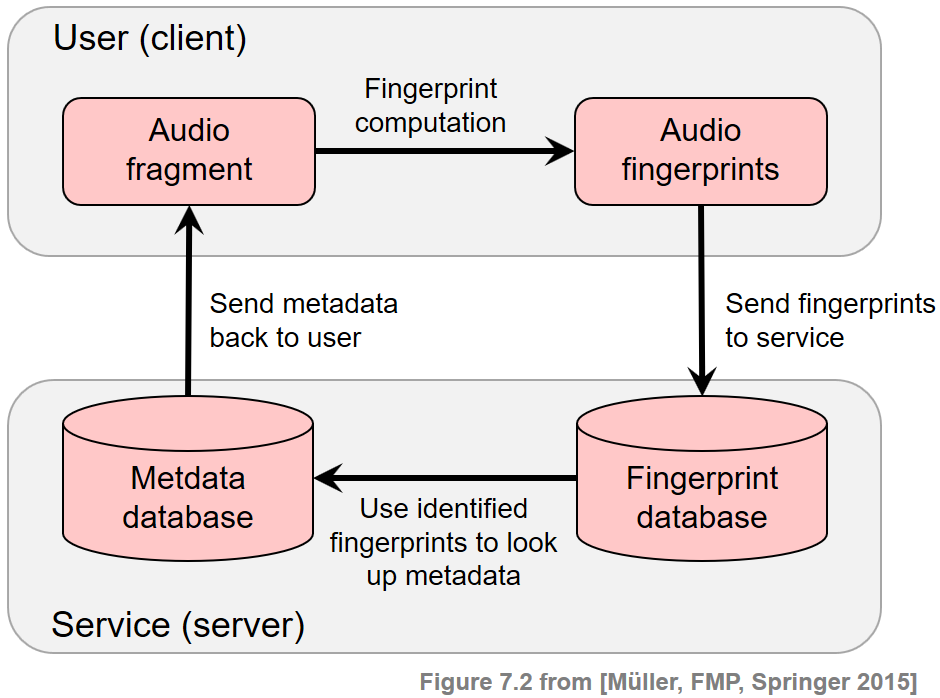

In [3]:
Image(path_img+"FMP_C7_F02.png", width="500px")

- 내용 기반 음악 검색 영역 내에서 오디오 식별 작업은 학술 연구와 산업 모두에서 많은 관심을 받았다. 오디오 식별 기술은 이제 방송 및 저작권 모니터링과 같은 많은 상용 응용 프로그램이나 메타데이터 및 기타 콘텐츠 정보를 제공하기 위한 부가 가치 서비스에 통합된다.

## 일반적 요구사항 (General Requirements)

- 실제 음악 인식 시스템은 강력하고 계산적으로 효율적이어야 하므로 해결해야 할 기술적 과제가 많다. 특히 이러한 시스템에 사용되는 오디오 지문(fingerprints)은 높은 특이성, 견고성, 소형화 및 확장성을 비롯한 특정 요구 사항을 충족해야 한다.
    * **Specificity**(특이성): 오디오 지문은 몇 초의 오디오 조각으로도 해당 녹음을 안정적으로 식별하고 수백만 개의 다른 녹음과 구별할 수 있도록 높은 특이성을 가져야 한다.
    * **Robustness**(견고성): 신뢰할 만한 식별을 위해 지문은 손실 압축, 피치 이동, 시간 스케일링, 이퀄라이제이션 또는 동적 압축과 같은 배경 잡음 및 신호 왜곡에 대해 견고해야 한다.
    * **Compactness**(소형화): 오디오 지문은 대역폭(bandwidth)이 제한된 채널을 통해서도 전송될 수 있고 데이터베이스 측에 쉽게 저장 및 인덱싱될 수 있도록 하는 작은 크기여야 한다.
    * **Scalability**(확장성): 수백만 개의 녹음으로 확장하려면 오디오 지문 계산이 간단하고 효율적이어야 한다. 이는 처리 능력이 제한된 모바일 장치에서 지문을 계산할 때도 필요한 요구 사항이다.

- 특정 요구 사항을 개선하는 것은 종종 다른 요구 사항의 성능 저하를 의미하며 모순되는 원칙 간의 트레이드-오프에 직면해야 한다.
- 예를 들어 견고성을 높이면 일반적으로 잘못된 식별(오탐)이 증가하여 식별 시스템의 정확도가 떨어진다. 유사하게, 연산 및 소형화에서 유리하지만, 지문 크기의 과도한 감소는 식별 능력에 부정적인 영향을 미친다. 반대로 특이성과 견고성이 높은 지문은 계산에 광범위한 처리 능력이 필요한 경우 실제로 사용하지 못할 수 있다.

<table style="border:none;text-align:left;">
   <tr>
      <th style="border:none;text-align:left;">Short name</th> 
      <th style="border:none;text-align:left;">Type of distortion</th>
      <th style="border:none;text-align:left;">Audio</th>
   </tr>
    
   <tr>
      <td style="border:none;text-align:left;">Original</td> 
      <td style="border:none;text-align:left;">Original song</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>
   
   <tr>
      <td style="border:none;text-align:left;">Talking</td>  
      <td style="border:none;text-align:left;">Superposition with other sources <br>(e.g., people talking in background)</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Talking.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>
   
   <tr>
      <td style="border:none;text-align:left;">Noise</td>  
      <td style="border:none;text-align:left;">Superposition with Gaussian noise</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_NoiseSNR-9.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>
   
   <tr>
      <td style="border:none;text-align:left;">Coding</td>  
      <td style="border:none;text-align:left;">Strong coding artifacts</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_16kbits.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>

   <tr>
      <td style="border:none;text-align:left;">Faster</td> 
      <td style="border:none;text-align:left;">Time scale modification (faster)</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Faster.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>

   <tr>
      <td style="border:none;text-align:left;">Higher</td>  
      <td style="border:none;text-align:left;">Pitch shifting (higher)</td>
      <td style="border:none;text-align:left;">
         <audio style="width: 300px;" src="../data_FMP/FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_higher.wav" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>
</table>

## 스펙트럼 피크 기반의 오디오 지문 (Audio Fingerprints Based on Spectral Peaks)

- 이제 스펙트럼 피크의 개념을 기반으로 오디오 지문을 설명한다. 시간-주파수 평면의 특징적인 포인트이기 때문에 이러한 피크는 노이즈 및 추가 음원이 있는 경우에도 변경되지 않는 경우가 많다. Avery Wang이 소개한 피크 기반 지문은 이제 상업용 오디오 식별 시스템에서 성공적으로 사용되고 있다.

- 샘플링된 파형 형태의 오디오 신호가 주어지면 지문을 도출하는 첫 번째 단계는 STFT $\mathcal{X}$를 계산하는 것이다. $\mathcal{X}(n,k)$는 $n^{\mathrm{th}}$ 시간 프레임에 대한 $k^{\mathrm{th}}$ 푸리에 계수를 나타낸다. ($k\in [0:K]$ 및 $n\in\mathbb{Z}$)

- 이하에서 $k\in[0:K]$ 요소는 **주파수 스탬프**(**frequency stamp**)라고도 하고, $n\in\mathbb{Z}$ 요소는 **타임 스탬프**(**time stamp**)라고도 한다. 따라서 푸리에 계수 $\mathcal{X}(n,k)$의 좌표는 타임 스탬프 $n$ 및 주파수 스탬프 $k$로 구성된 시간-주파수 점 $(n,k)\in\mathbb{Z}\times[0:K]$로 지정된다. 

- 지문 계산의 두 번째 단계에서 신호의 STFT 표현은 희소한(sparse) 시간-주파수 포인트 집합으로 축소된다.

- 이를 위해 각 지점 주변의 영역 내 모든 이웃보다 더 큰 크기를 갖는 시간-주파수 지점을 식별하는 피크 선택 전략을 사용한다. 보다 정확하게는 $\tau\in\mathbb{N}$ 및 $\kappa\in\mathbb{N}$를 각각 시간 및 주파수 방향에서 **이웃**의 크기를 결정하는 매개변수라고 한다. 그런 다음 다음과 같은 경우 점 $(n_0,k_0)$이 피크로 선택된다.
    - $|X(n_0,k_0)| \geq  |X(n,k)|$
    - for all $(n,k) \in \big(\left[n_0-\tau:n_0+\tau\right] \times \left[k_0-\kappa:k_0+\kappa\right]\big)$.

- 이러한 정의는 스펙트로그램과 추출된 하나의 피크와 그것의 로컬 이웃을 보여주는 다음 그림에 설명되어 있다. 이웃의 크기를 늘리면 점을 선택하기가 더 어려워진다. 따라서 $\tau$ 및 $\kappa$ 매개변수를 사용하여 선택한 피크의 밀도를 조정하고 시간-주파수 평면의 상당히 균일한 커버리지를 얻을 수 있다.

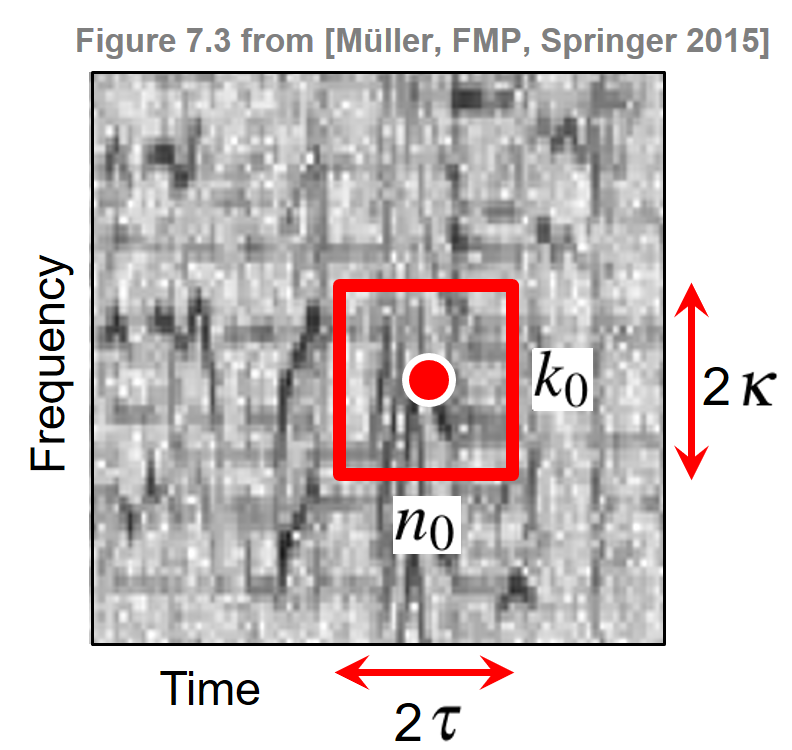

In [4]:
Image(path_img+"FMP_C7_F03a.png", width="300px")

## Constellation Map

- 피크 선택 단계는 신호의 복잡한 스펙트로그램 표현을 희소한 좌표 세트로 줄인다. 피크의 크기는 더 이상 사용되지 않으며 피크의 시간 및 주파수 스탬프만 고려되어 높은 수준의 견고성을 제공한다. 모든 피크 좌표로 구성된 표현을 **constellation map**이라고 한다.

- 다음 코드 셀에서 주어진 **이웃 매개변수** $\tau$ 및 $\kappa$에 대한 constellation map을 추출하기 위한 다소 나이브한 구현을 본다. 이 구현에서는 모든 시간-주파수 지점을 반복하고 이웃 조건($\kappa$ 및 $\tau$로 지정)이 충족되는지 확인한다. 그림은 위의 Beatles 예제에 대한 constellation map(빨간색으로 표시된 추출된 피크 지문)과 함께 스펙트로그램 표현을 보여준다.

In [5]:
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (naive implementation)
    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap


def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map
    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

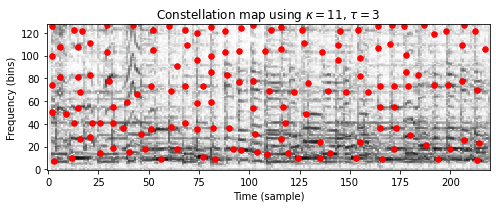

In [6]:
wav_dict = {}
wav_dict['Original'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4.wav'
wav_dict['Noise'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_NoiseSNR-9.wav'
wav_dict['Talking'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Talking.wav'
wav_dict['Coding'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_16kbits.wav'
wav_dict['Faster'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Faster.wav'
wav_dict['Higher'] = 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Higher.wav'


fn_wav = wav_dict['Original']
Y = compute_spectrogram(path_data+fn_wav)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 3   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), 
                                     color='r', s=30, title=title)

나이브하고 반복적인 구현에 대한 대안으로 다음 코드 셀에서 다차원 이미지 처리를 위한 Python 패키지 `scipy.ndimage`를 사용하여 훨씬 더 빠른 구현을 제공한다. 다음 코드 셀에서 두 구현의 결과(동일해야 함)와 런타임을 비교한다.

In [7]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)
    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

Runtime of naive (iterative) implementation: 0.14860797 seconds
Runtime of fast (scipy.ndimage) implementation: 0.00055876 seconds


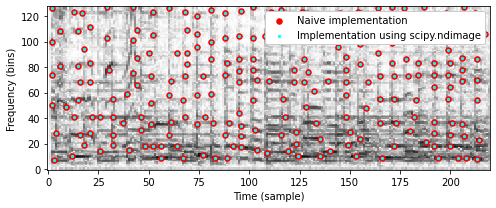

In [8]:
dist_freq = 7  # kappa: neighborhood in frequency direction
dist_time = 3  # tau: neighborhood in time direction

start = time.time()
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of naive (iterative) implementation: %.8f seconds' % (end - start))

start = time.time()
for i in range(100):
    Cmap = compute_constellation_map(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of fast (scipy.ndimage) implementation: %.8f seconds' % ((end - start)/100))

fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), color='r', s=30)
n, k = np.argwhere(Cmap == 1).T
ax.scatter(k, n, color='cyan', s=5, marker='o')
plt.legend(['Naive implementation', 'Implementation using scipy.ndimage'], 
           loc='upper right', framealpha=1);

### Constellation map의 robustness

- 앞서 설명한 바와 같이 지문 시스템은 배경 잡음과 신호 왜곡에 강해야(robust) 한다. 다음 코드 셀에서는 원래 Beatles 예제(`Original`), 가우시안 노이즈가 중첩된 버전(`Noise`), 배경 노이즈가 있는 버전(`Talking`), 코딩 아티팩트(`coding`)에 의해 왜곡된 버전에 대한 constellation map을 보여준다. 또한 이웃 매개변수 $\kappa$ 및 $\tau$로 constellation map의 밀도를 제어할 수 있는 방법을 설명한다. 두 매개변수 설정에서 다음을 관찰할 수 있다.
    * 왜곡된 버전의 constellation map는 원본 버전과 일부 피크를 공유한다.
    * 왜곡된 버전의 피크는 때때로 원래 버전의 피크와 비교하여 시간 및/또는 주파수가 약간 이동한다.

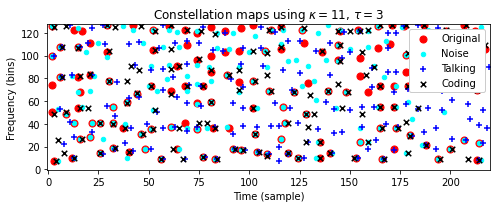

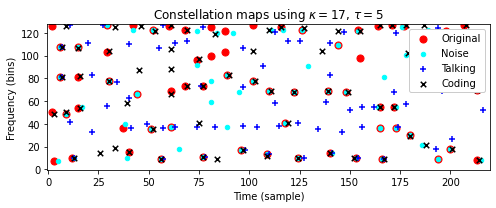

In [9]:
def compare_constellation_maps_Beatles(dist_freq = 11, dist_time = 3, wav_dict=wav_dict):
    fn_wav = wav_dict['Original']
    Y = compute_spectrogram(path_data+fn_wav)
    Cmap = compute_constellation_map(Y, dist_freq, dist_time)

    fn_wav = wav_dict['Noise']
    Y_noise = compute_spectrogram(path_data+fn_wav)
    Cmap_noise = compute_constellation_map(Y_noise, dist_freq, dist_time)

    fn_wav = wav_dict['Talking']
    Y_noise = compute_spectrogram(path_data+fn_wav)
    Cmap_talking = compute_constellation_map(Y_noise, dist_freq, dist_time)
    
    fn_wav = wav_dict['Coding']
    Y_coding = compute_spectrogram(path_data+fn_wav)
    Cmap_coding = compute_constellation_map(Y_coding, dist_freq, dist_time)

    title=r'Constellation maps using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
    fig, ax, im = plot_constellation_map(Cmap, color='r', s=50,title=title)
    
    n, k = np.argwhere(Cmap_noise == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    
    n, k = np.argwhere(Cmap_talking == 1).T
    ax.scatter(k, n, color='blue', s=40, marker='+')

    n, k = np.argwhere(Cmap_coding == 1).T
    ax.scatter(k, n, color='k', s=30, marker='x')
    plt.legend(['Original', 'Noise', 'Talking', 'Coding'], loc='upper right', framealpha=1)
    return Cmap, Cmap_noise, Cmap_talking, Cmap_coding

compare_constellation_maps_Beatles(dist_freq = 11, dist_time = 3)
compare_constellation_maps_Beatles(dist_freq = 17, dist_time = 5);

## 피크 매칭의 평가 지표

- 실제로는 왜곡이 있는 경우에도 (시간 및 주파수 방향에 약간의 허용 오차를 허용하면서)일치하는 작은 비율의 피크가 녹음을 성공적으로 식별하는 데 충분하다는 것이 밝혀졌다.
- 이 관찰은 아래에서 설명할 일치 절차의 기초이다. 이제 두 constellation map 간의 일치를 나타내는 몇 가지 **평가 측정**을 소개한다.
- 첫 번째 constellation map은 **레퍼런스**(**맞는 것으로 간주되는 피크**)로 해석하고 두 번째 constellation map는 **추정**(**추정되는 것으로 간주되는 피크**)으로 해석한다. 이를 통해 **true positives**(TP), **false positives**(FP) 및 **false negatives**(FN)과 같은 용어를 사용할 수 있다.


- 다음 코드 셀에서는 **tolerance**를 어느 정도 허용하면서 TP, FP, FN 값을 측정하는 기능을 구현한다.

In [10]:
def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    """| Compare binary matrices with tolerance
    | Note: The tolerance parameters should be smaller than the minimum distance of
      peaks (1-entries in C_ref ad C_est) to obtain meaningful TP, FN, FP values

    Args:
        C_ref (np.ndarray): Binary matrix used as reference
        C_est (np.ndarray): Binary matrix used as estimation
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 0)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 0)

    Returns:
        TP (int): True positives
        FN (int): False negatives
        FP (int): False positives
        C_AND (np.ndarray): Boolean mask of AND of C_ref and C_est (with tolerance)
    """
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND


def compare_constellation_maps(fn_wav_D, fn_wav_Q, dist_freq = 11, dist_time = 5, 
                               tol_freq = 1, tol_time = 1):
    Y_D = compute_spectrogram(fn_wav_D)
    Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q)
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q, 
                                                     tol_freq=tol_freq, tol_time=tol_time)
    title=r'Matching result (tol_freq=%d and tol_time=%d): TP=%d, FN=%d, FP=%d' % \
        (tol_freq,tol_time, TP, FN, FP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimation'], loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()

====== Reference: Original; Estimation: Noise ======


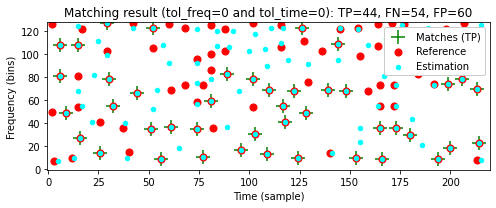

====== Reference: Original; Estimation: Noise ======


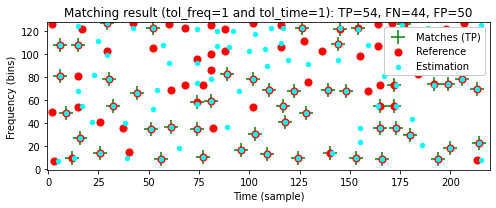

====== Reference: Original; Estimation: Coding ======


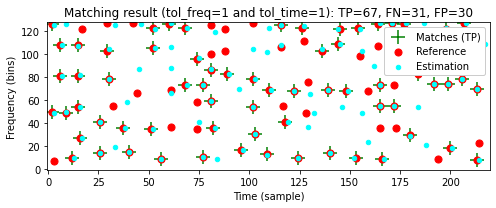

====== Reference: Original; Estimation: Talking ======


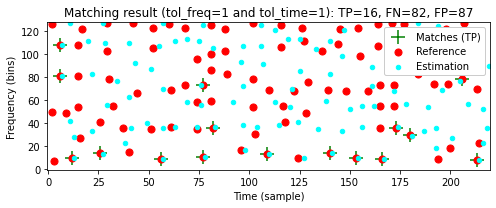

In [11]:
fn_wav_D = path_data + wav_dict['Original']

fn_wav_Q = path_data + wav_dict['Noise']
tol_freq = 0
tol_time = 0
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

fn_wav_Q = path_data+wav_dict['Coding']
tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Coding ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

fn_wav_Q = path_data+wav_dict['Talking']
tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Talking ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

## 매칭 함수 (Matching Function)

- $\mathcal{Q}$라는 짧은 쿼리 오디오 조각과 $\mathcal{D}$라는 데이터베이스 녹음을 고려해 생각해보자. 또한, $\mathcal{C}(\mathcal{Q})$ 및 $\mathcal{C}(\mathcal{D})$는 $\mathcal{Q}$ 및 $\mathcal{D}$ 각각의 constellation map를 나타낸다. 

- 쿼리 $\mathcal{Q}$가 녹음 $\mathcal{D}$에 포함되어 있는 경우 constellation map $\mathcal{C}(\mathcal{Q})$는 constellation map $\mathcal{C}(\mathcal{D})$ 내의 해당 섹션과 어느 정도 일치해야 한다. 직관적으로 오디오 식별의 기본 아이디어는 스트립 차트에 $\mathcal{D}$의 map을 놓고 투명한 플라스틱 조각 위에 $\mathcal{Q}$의 map를 배치하는 것이다.

- 일치하는 포인트의 수가 많은 경우 쿼리가 문서에 포함된 것으로 간주된다. $\mathcal{C}(\mathcal{D})$ 내에서 일치하는 위치의 적절한 시간 오프셋은 이동(shift)으로 주어진다.

- 이제 대략적인 매칭 절차를 공식화하자. 피크 위치는 타임스탬프 $n\in\mathbb{Z}$와 주파수스탬프 $k\in[0:K]$로 구성된 좌표 $(n,k)$로 지정된다. constellation map은 그러한 좌표의 유한 집합이다. 이전과 마찬가지로 $\mathcal{C}(\mathcal{Q})\subset \mathbb{Z}\times[0:K]$ 및 $\mathcal{C}(\mathcal{D})\subset \mathbb {Z}\times[0:K]$는 각각 쿼리 $\mathcal{Q}$ 및 문서 $\mathcal{D}$의 constellation map이다.

- 쿼리를 $m\in\mathbb{Z}$ 위치만큼 이동하면 다음에 의해 정의된 constellation map $m+\mathcal{C}(\mathcal{Q})$가 생성된다.
    - $ m+\mathcal{C}(\mathcal{Q}) := \left\{(m+n,k) \mid (n,k)\in \mathcal{C}(\mathcal{Q}) \right\}.$

- 이동된 쿼리와 데이터베이스 문서 간에 일치하는 피크 좌표를 계산하려면 해당 constellation map을 교차하고 결과 집합의 크기를 결정하기만 하면 된다. 이는 다음에 의해 정의된 매칭 함수(matching function) $\Delta_\mathcal{C}:\mathbb{Z}\to\mathbb{N}_0$를 생성한다.
    - $ \Delta_\mathcal{C}(m):= \big| (m+\mathcal{C}(\mathcal{Q}))\cap  \mathcal{C}(\mathcal{D}) \big|$
    - for $m\in\mathbb{Z}$.
    
- 일반적으로 쿼리와 데이터베이스 문서가 관련이 없을 때 (동시에) 일치하는 피크 위치의 수 $\Delta_\mathcal{C}(m)$는 $|\mathcal{C}(\mathcal{Q})|$에 비해 일반적으로 작다.
- 쿼리가 데이터베이스 문서에 포함된 경우에만 매칭 함수가 일부 이동 인덱스 $m\in\mathbb{Z}$에 대해 큰 값 $\Delta_\mathcal{C}(m)$를 갖는다. 이 인덱스는 쿼리 $\mathcal{Q}$와 $\mathcal{D}$의 일치 섹션 사이의 시간 오프셋을 나타낸다.

- 다음 코드 셀에서는 작은 편차(허용 오차 매개변수 `tol_freq` 및 `tol_time`으로 지정됨)도 허용하는 일반화된 매칭 함수 $\Delta_\mathcal{C}$에 대한 구현을 확인한다.
     * $\Delta_\mathcal{C}(m)$를 계산할 때 이동된 쿼리 $m+\mathcal{C}(\mathcal{Q})$는 $\mathcal{C}(\mathcal{D})$와 비교된다. 이는 $m$ 위치에서 쿼리와 길이가 같은 $\mathcal{C}(\mathcal{D})$ 섹션을 잘라내고, 이 섹션을 $\mathcal{C}(\mathcal{Q})$와 비교하는 것과 같다.
     * $\mathcal{Q}$와 $\mathcal{D}$의 constellation map를 비교할 때 일치하는 피크의 수를 봐야 한다. 이는 $\mathcal{D}$를 참조로, $\mathcal{Q}$를 추정으로 볼 때 true positive(TP)의 수에 해당한다.
     * 비교에서는 두 개의 허용 오차 매개변수인 `tol_freq` 및 `tol_time`이 있는 `match_binary_matrices_tol` 함수를 사용한다. 이러한 매개변수를 $0$ 값으로 설정하면 위에서 소개한 대로 $\Delta_\mathcal{C}$ 매칭 함수가 생성된다.

- $\mathcal{D}$로 `Original`을 사용하고 $\mathcal{Q}$로 `Noise`의 세그먼트 $[100:149]$(샘플에서 제공됨)를 사용하는 Beatles 예제를 보자. 다음 그림은 다양한 허용오차 매개변수에 대한 매칭 함수를 보여준다. 이러한 함수는 이동 위치 $m=100$에서 최대값을 가정한다.

In [12]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    """Computes matching function for constellation maps

    Args:
        C_D (np.ndarray): Binary matrix used as dababase document
        C_Q (np.ndarray): Binary matrix used as query document
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 1)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 1)

    Returns:
        Delta (np.ndarray): Matching function
        shift_max (int): Optimal shift position maximizing Delta
    """
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max

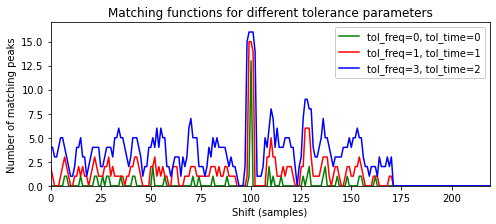

In [13]:
dist_freq = 11
dist_time = 5

fn_wav_D = path_data+wav_dict['Original']
Y_D = compute_spectrogram(fn_wav_D)
Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)

fn_wav_Q = path_data+wav_dict['Noise']
Y_Q = compute_spectrogram(fn_wav_Q)
Y_Q = Y_Q[:, 100:150]
Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

Delta_0, shift_max_0 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=0, tol_time=0)
Delta_1, shift_max_1 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=1, tol_time=1)
Delta_2, shift_max_2 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=3, tol_time=2)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = plot_signal(Delta_0, ylim=[0, y_max], color='g',
                                     xlabel='Shift (samples)', ylabel='Number of matching peaks', 
                                     figsize=(7, 3))
plt.title('Matching functions for different tolerance parameters')
ax.plot(Delta_1, color='r')
ax.plot(Delta_2, color='b')
plt.legend(['tol_freq=0, tol_time=0', 'tol_freq=1, tol_time=1', 
            'tol_freq=3, tol_time=2'], loc='upper right', framealpha=1)
plt.show()

- 다음 코드 셀에서는 서로다른 이동 인덱스 $m$에 대해 이동된 쿼리 $m+\mathcal{C}(\mathcal{Q})$와 $\mathcal{C}(\mathcal{D})$ 간의 로컬 일치 결과를 보여준다. $m=0$에 대해 일치하는 피크가 거의 없는 반면, 최적 이동 지수 $m=99$에 대해 일치하는 피크는 많다.

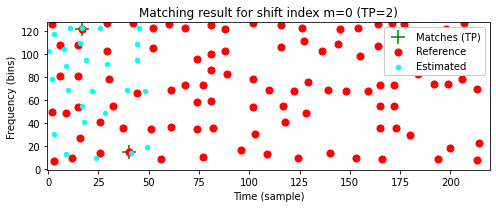

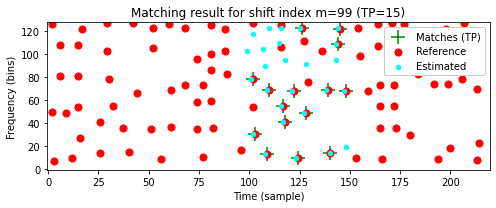

In [14]:
def plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0):
    Cmap_Q_extend = np.zeros(Cmap_D.shape) 
    Cmap_Q_extend[:, shift:shift+Cmap_Q.shape[1]] = Cmap_Q
    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q_extend, 
                                                     tol_freq=1, tol_time=1)
    title=r'Matching result for shift index m=%d (TP=%d)' % (shift, TP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q_extend == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimated'], loc='upper right', framealpha=1)
    plt.show()
    
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0)    
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=shift_max_1) 

- 이제 서로 다른 버전의 Beatles 예에서 얻은 매칭 함수를 살펴보자. 이전과 마찬가지로 `Original`을 $\mathcal{D}$로 사용하고 다른 버전의 세그먼트 $[100:149]$(샘플에서 제공)를 $\mathcal{Q}$로 사용한다. 다음 그림은 `Original`, `Noise`, `Coding` 및 `Talking` 쿼리에 대한 매칭 함수를 보여준다. 처음 세 개의 쿼리에 대해 예상되는 매칭 위치에서 매칭 함수에서 뚜렷한 최대값을 관찰할 수 있지만 'Talking' 쿼리는 식별하기가 훨씬 더 어렵다.

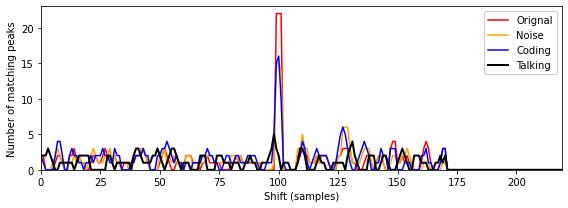

In [21]:
def compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=150, dist_freq=11, 
                  dist_time=5, tol_freq=1, tol_time=1):
    Y_D = compute_spectrogram(fn_wav_D)
    Cmap_D = compute_constellation_map(Y_D, dist_freq=dist_freq, dist_time=dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q)
    Y_Q = Y_Q[:, seg_start:seg_end]
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq=dist_freq, dist_time=dist_time)
    Delta, shift_max = compute_matching_function(Cmap_D, Cmap_Q, 
                                                 tol_freq=tol_freq, tol_time=tol_time)
    return Delta, shift_max

fn_wav_Q = path_data+wav_dict['Original']   
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = path_data+wav_dict['Noise']
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = path_data+wav_dict['Coding']
Delta_2, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = path_data+wav_dict['Talking']
Delta_3, shift_max_3 = compute_Delta(fn_wav_D, fn_wav_Q)

y_max = Delta_0[shift_max_0] + 1
fig, ax, line = plot_signal(Delta_0, ylim=[0, y_max], color='r',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3))
ax.plot(Delta_1, color='orange')
ax.plot(Delta_2, color='b')
ax.plot(Delta_3, color='k', linewidth='2')
plt.legend(['Orignal', 'Noise', 'Coding', 'Talking'], loc='upper right', framealpha=1)
plt.show()

- 위의 예에서 `Talking` 버전의 $[100:149]$ 세그먼트(샘플에서 제공)를 사용할 때 `Original` Beatles 노래의 올바른 세그먼트를 거의 식별할 수 없는 것을 확인했다. 쿼리 배열 맵의 **판별력**(discriminative power)을 높이는 한 가지 방법은 지속 시간을 늘리는 것이다. 이를 시연하기 위해 다음 그림에서 길이가 다른 쿼리에 대한 매칭 함수를 보여준다.

    * Segment $[100:149]$ (corresponding to 2.32 seconds)
    * Segment $[100:174]$ (corresponding to 3.48 seconds)
    * Segment $[100:199]$ (corresponding to 4.64 seconds)

- 가장 긴 쿼리의 경우 심하게 왜곡된 'Talking' 버전의 경우에도 피크 구조가 더 두드러진다.

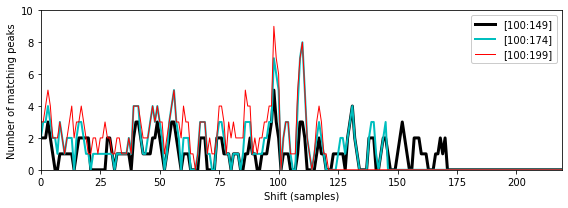

In [24]:
fn_wav_Q = path_data+wav_dict['Talking']
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q)
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=175)
Delta_2, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=200)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = plot_signal(Delta_0, ylim=[0, y_max], color='k',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3), linewidth=3)
ax.plot(Delta_1, color='c', linewidth=2)
ax.plot(Delta_2, color='r', linewidth=1)
plt.legend(['[100:149]', '[100:174]', '[100:199]'], loc='upper right', framealpha=1)
plt.show()

- 'Faster'(타임스케일 수정 버전이 약 10% 더 빠르게 재생됨)와 'Higher'(피치 이동 버전)의 두 가지 버전을 고려해보자.
- 다시 `Original`을 $\mathcal{D}$로 사용하고 다른 버전의 세그먼트 $[100:174]$를 $\mathcal{Q}$로 사용하면 다음 그림에서 결과 매칭 함수를 보여준다. 위에서 정의한 대로 매칭 함수는 다소 엄격한 의미에서 constellation map을 비교한다. 즉, 주파수의 체계적 이동과 전역적 시간 확장은 고려되지 않는다.
- 결과적으로 지금까지 논의된 기술로는 'Faster' 또는 'Higher'와 같은 버전을 식별할 수 없다.

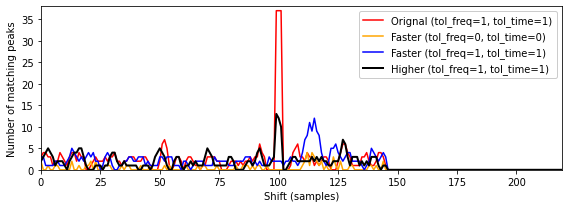

In [28]:
fn_wav_Q = path_data+wav_dict['Original']
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)
fn_wav_Q = path_data+wav_dict['Faster']
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=0, tol_time=0)
Delta_2, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)
fn_wav_Q = path_data+wav_dict['Higher']
Delta_3, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)

y_max = Delta_0[shift_max_0] + 1
fig, ax, line = plot_signal(Delta_0, ylim=[0, y_max], color='r',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3))
ax.plot(Delta_1, color='orange')
ax.plot(Delta_2, color='b')
ax.plot(Delta_3, color='k', linewidth='2')
plt.legend([r'Orignal (tol_freq=1, tol_time=1)', r'Faster (tol_freq=0, tol_time=0)', 
            r'Faster (tol_freq=1, tol_time=1)', r'Higher (tol_freq=1, tol_time=1)'], loc='upper right', framealpha=1)
plt.show()

## 인덱싱(Indexing)

- 지금까지 설명한 매칭 과정에서 쿼리는 데이터베이스에 포함된 모든 문서의 모든 섹션(쿼리와 동일한 기간을 가짐)에 대해 비교되어야 한다.
- 실행 시간이 문서의 수와 크기에 선형적으로 의존하는 이러한 철저한 검색 전략은 수백만 개의 녹음이 포함된 대규모 데이터베이스에는 적합하지 않다. 확장성 측면에서 검색 결과의 정확성을 희생하지 않으면서 빠른 정보 접근을 용이하게 하는 검색 전략이 필요하다.
- 이러한 검색 전략은 일반적으로 적절한 조회 작업을 통해 검색 공간을 줄여 속도와 성능을 최적화하는 **인덱싱** 기술을 사용한다. **인덱스**는 알파벳순으로 정렬된 **키워드**(일반적으로 **해시**(hash)라고 함) 모음으로 구성된 전통적인 책 색인과 유사하게 구성된다. 각 키워드에 대해 차례로 책에서 주어진 키워드의 발생을 나타내는 증가하는 페이지 번호 목록이 있다.
- 오디오 지문의 맥락에서 키워드(또는 해시)는 피크(또는 그 조합)의 주파수 값(적절하게 양자화됨)인 반면, 페이지 번호는 시간 위치 및 문서 식별자에 해당한다.

## 피크 쌍 (Peak Pairs)

- 노이즈와 왜곡에 견고하더라도, 개별 스펙트럼 피크는 고립된 방식으로 고려될 때 그다지 특징적이지 않다는 점에서 특이성(specificity)이 낮다. 결과적으로 개별 스펙트럼 피크와 주파수 스탬프를 해시 값으로 사용하면 결과 해시 목록("페이지 번호 목록")이 길어지고 인덱싱이 느려지는 것으로 나타난다. 
- 따라서 Wang이 도입한 지문 시스템의 한 가지 중요한 단계는 지문의 견고성을 희생하지 않고 해시의 특이성과 수를 증가시키는 것이다(따라서 결과 해시 목록의 길이를 줄임). 주요 아이디어는 개별 피크가 아닌 피크 쌍을 고려하여 지문 해시를 형성하는 것이다. 이를 위해 $(n_0,k_0)\in\mathcal{C}(\mathcal{D})$ 포인트 고정하는데 이는 그와 관련된 **앵커(anchor) 포인트** 및 **타겟 영역(target zone)** $T_{(n_0,k_0)}\subset\mathbb{Z}\times[0:K]$이라고 볼 수 있다.

- 타겟 영역은 앵커 포인트에 가까운 시간-주파수 평면의 작은 직사각형 영역으로 생각되어야 한다. 그런 다음, 앵커 포인트 $(n_0,k_0)$ 및 일부 타겟 포인트 $(n_1,k_1)\in T_{(n_0,k_0)}\cap\mathcal{C}(\mathcal{D})$로 구성되는 포인트 쌍 $\big((n_0,k_0),(n_1,k_1)\big)$을 고려한다.
- 각 쌍은 두 개의 주파수 스탬프와 두 개의 타임 스탬프의 차이로 구성된 트리플 $(k_0,k_1,n_1-n_0)$을 산출한다. 단일 주파수 스탬프 대신 이러한 트리플을 해시로 사용하는 것이다.

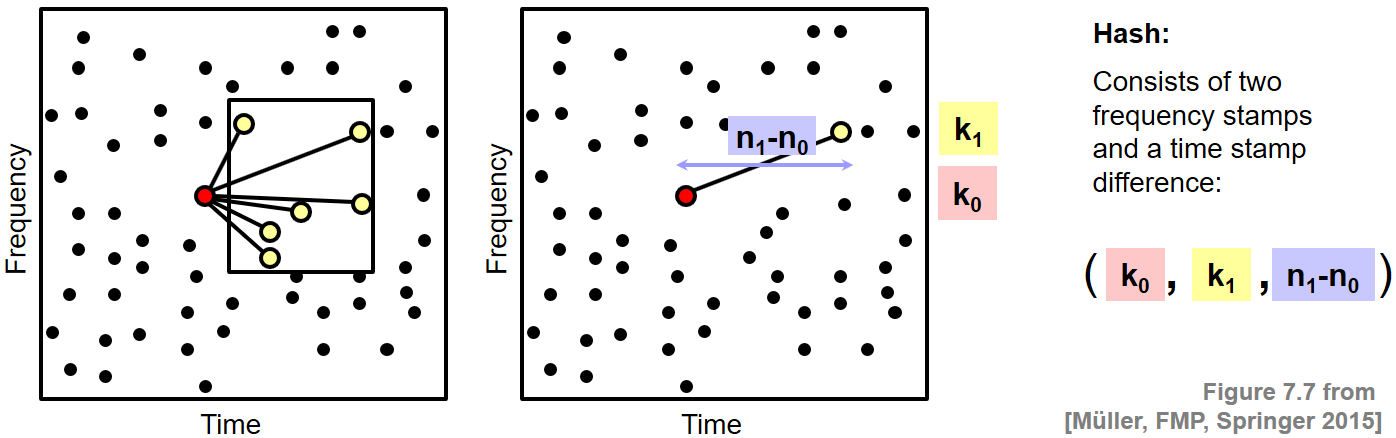

In [31]:
Image(path_img+"FMP_C7_F07.png", width="700px")

- 매칭 단계에서 이제 일치하는 주파수 스탬프만 고려하는 대신 이동된 쿼리와 데이터베이스 문서 간의 일치하는 트리플을 계산한다.
- 인덱싱할 데이터 항목의 수가 증가하더라도(단일 주파수 스탬프 대신 트리플을 고려하여) 트리플의 훨씬 더 높은 특이성 덕분에 검색 프로세스에서 엄청난 가속을 얻는다는 것을 보여줄 수 있다.

# 결론

- 최근에는 다양한 지문 및 인덱싱 기술이 제안되어 현재 상용 제품에 사용되고 있다. 원래 Shazam 오디오 식별 시스템용으로 개발된 이러한 기술 중 하나를 자세히 살펴보았다. 시스템의 기본 아이디어에 대해 논의했지만 견고성, 특이성, 확장성 및 소형화를 포함한 다양한 요구 사항 사이에서 적절한 절충점을 찾기 위해 조정해야 하는 많은 매개변수가 있다.

- 중요한 측면은 다음과 같다.
     * 시간 및 스펙트럼 해상도를 결정하는 STFT 매개변수(윈도우 길이, 홉 크기)
     * 피크 선택 전략(이웃 매개변수 포함)
     * 타겟 영역의 크기(triplet을 정의하는 데 사용됨)
     * 해싱(hashing)에 적합한 데이터 구조

- 많은 종류의 신호 왜곡에 견고하지만 논의된 지문 접근 방식은 시간적 변형을 처리하도록 설계되지 않았다. constellation 맵의 매칭과 피크 쌍의 타임스탬프 차이는 둘 다 쿼리와 데이터베이스 문서 간의 상대적인 템포 차이에 민감하다. 따라서 시간 스케일의 수정에 불변이 되기 위해서는 다른 기술이 필요하다.

- 스펙트럼 피크를 사용하는 지문은 특정 버전의 음악에 매우 민감하도록 설계되었다. 예를 들어, 동일한 아티스트의 노래에 대한 다양한 연주가 주어지면 지문 시스템은 인간의 귀로 거의 구별할 수 없는 경우에도 올바른 것을 선택할 가능성이 높다. 일반적으로 오디오 식별 시스템은 데이터베이스에 이미 존재하는 녹음의 식별을 목표로 설계되었다. 따라서 이러한 기술은 일반적으로 데이터베이스의 일부가 아닌 라이브 녹음이나 공연으로까지 일반화되지 않는다.